## TIC TAC TOE using Reinforcement Learning

In [1]:
# import libraries

import random
import numpy as np
import matplotlib.pyplot as plt

import IPython.display as display
import sys
import time


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


2023-05-19 12:14:37.468634: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Architecture of the Game

In [2]:
# Define my custom Environement

class TicTacToeEnvironment:
    def __init__(self):
        self.board = np.zeros((3, 3), dtype=int)
        self.current_player = 1
        self.game_over = False

    def reset(self):
        self.board = np.zeros((3, 3), dtype=int)
        self.current_player = 1
        self.game_over = False

    def get_state(self):
        # Return the current state of the board
        return self.board.flatten()

    def get_valid_actions(self):
        # Return a list of available actions (indices) on the board
        #return np.where(self.board.flatten() == 0)[0]
        return list(np.where(self.board.flatten() == 0)[0])

    def is_valid_action(self, action):
        # Check if the given action is valid
        return self.board.flatten()[action] == 0
    

    def update(self, action):
        # Update the board state with the given action
        self.board[action // 3, action % 3] = self.current_player

        # Check for a win or draw
        if self.check_winner(self.current_player):
            self.game_over = True
            return 1.0  # Reward for winning
        elif self.is_board_full():
            self.game_over = True
            return 0.5  # Reward for draw
        else:
            self.current_player = -self.current_player
            return 0.0  # Reward for ongoing game
     


    def check_winner(self, player):
        # Check if the given player has won the game
        win_combinations = [
            [0, 1, 2], [3, 4, 5], [6, 7, 8],  # Rows
            [0, 3, 6], [1, 4, 7], [2, 5, 8],  # Columns
            [0, 4, 8], [2, 4, 6]  # Diagonals
        ]
        for combination in win_combinations:
            if np.all(self.board.flatten()[combination] == player):
                return True
        return False

    
    
    def is_board_full(self):
        # Check if the board is full (draw)
        return np.all(self.board.flatten() != 0)
    
    def print_board(self):
        print("-------------")
        for i in range(3):
            print("|", end=" ")
            for j in range(3):
                symbol = " "
                if self.board[i][j] == -1:
                    symbol = "X"
                elif self.board[i][j] == 1:
                    symbol = "O"
                print(symbol, end=" | ")
            print("\n-------------")
    

In [3]:
#define the QNetwork class


class QNetwork:
    def __init__(self, state_size, action_size, learning_rate, discount_factor):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.model = self.build_model()

    def build_model(self):
        model = keras.Sequential([
            layers.Dense(64, activation='relu', input_shape=(self.state_size,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(self.action_size, activation='softmax')
        ])
        optimizer = keras.optimizers.Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error')
        return model

    def predict(self, state):
        return self.model.predict(state, verbose=0)

    def update(self, states, targets_full):
        self.model.fit(states, targets_full, epochs=1, verbose=0)


In [4]:
# define the replay buffer for sampling experiences

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.dones = []
        
    def store_experience(self, state, action, reward, next_state, done):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.next_states.append(next_state)
        self.dones.append(done)

        if len(self.states) > self.capacity:
            self.states.pop(0)
            self.actions.pop(0)
            self.rewards.pop(0)
            self.next_states.pop(0)
            self.dones.pop(0)
            
    def sample_experiences(self, batch_size):
        indices = np.random.choice(len(self.states), size=batch_size, replace=False)

        batch_states = [self.states[i] for i in indices]
        batch_actions = [self.actions[i] for i in indices]
        batch_rewards = [self.rewards[i] for i in indices]
        batch_next_states = [self.next_states[i] for i in indices]
        batch_dones = [self.dones[i] for i in indices]

        return batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones
    
    

In [5]:
# define my agent class

class Agent:
    def __init__(self, q_network, episodes, epsilon=1.0, epsilon_min=0.001, learning_rate=0.001, discount_factor=0.99):
        self.q_network = q_network
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.episodes = episodes
        self.epsilon_decay = self.calculate_epsilon_decay()
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor

    def calculate_epsilon_decay(self):
        epsilon_decay = (self.epsilon_min / self.epsilon) ** (1.0 / self.episodes)
        return epsilon_decay

    def choose_action(self, state, valid_actions):
        if self.epsilon > self.epsilon_min:
            if np.random.rand() < self.epsilon:
                return random.choice(valid_actions)
            else:
                q_values = self.q_network.predict(np.array([state]))
                q_values = q_values.flatten()
                q_values_valid = [q_values[action] for action in valid_actions]
                return valid_actions[np.argmax(q_values_valid)]
        else:
            q_values = self.q_network.predict(np.array([state]))
            q_values = q_values.flatten()
            q_values_valid = [q_values[action] for action in valid_actions]
            return valid_actions[np.argmax(q_values_valid)]

    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            self.epsilon = max(self.epsilon, self.epsilon_min)

    def play(self, state, valid_actions):
        q_values = self.q_network.predict(np.array([state]))
        q_values = q_values.flatten()
        q_values_valid = [q_values[action] for action in valid_actions]
        return valid_actions[np.argmax(q_values_valid)]

    def update_q_network(self, states, targets_full):
        self.q_network.update(states, targets_full)

    



<br>

## Training

In [6]:

def train_agent(agent1, agent2, environment, replay_buffer, batch_size, episodes=10000, learning_rate=0.001, discount_factor=0.99):
    rewards = []  # List to store the episode rewards
    wins = 0
    draws = 0
    losses = 0
    cumulative_rewards = []  # List to store cumulative rewards
    epsilons = []  # List to store epsilon values

    for episode in range(1, episodes + 1):
        environment.reset()
        state = environment.get_state()
        done = False
        player1_moves = 0  # Counter for player 1 moves

        while not done:
            if environment.current_player == 1:
                action = agent1.choose_action(state, environment.get_valid_actions())
                player1_moves += 1  # Increment moves counter for player 1
            else:
                action = agent2.choose_action(state, environment.get_valid_actions())

            reward = environment.update(action)
            next_state = environment.get_state()
            done = environment.game_over

            replay_buffer.store_experience(state, action, reward, next_state, done)

            if len(replay_buffer.states) >= batch_size:
                batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = replay_buffer.sample_experiences(batch_size)

                if environment.current_player == 1:
                    targets = batch_rewards + np.max(agent1.q_network.predict(np.array(batch_next_states)), axis=1) * (1 - np.array(batch_dones))
                    targets_full = agent1.q_network.predict(np.array(batch_states))
                    targets_full[np.arange(batch_size), np.array(batch_actions)] = targets
                    agent1.update_q_network(np.array(batch_states), targets_full)
                else:
                    targets = batch_rewards + np.max(agent2.q_network.predict(np.array(batch_next_states)), axis=1) * (1 - np.array(batch_dones))
                    targets_full = agent2.q_network.predict(np.array(batch_states))
                    targets_full[np.arange(batch_size), np.array(batch_actions)] = targets
                    agent2.update_q_network(np.array(batch_states), targets_full)

            state = next_state

        agent1.update_epsilon()
        agent2.update_epsilon()

        if reward == 1.0 and environment.current_player == 1:
            wins += 1
            outcome = 'Win'
        elif reward == 0.5:
            draws += 1
            outcome = 'Draw'
        else:
            losses += 1
            outcome = 'Loss'
            reward = -1.0

        rewards.append(reward)
        cumulative_rewards.append(sum(rewards))  # Calculate cumulative rewards
        epsilons.append(agent1.epsilon)  # Store epsilon value

        # Print episode statistics for player 1
        print(f"Episode: {episode}, Player 1 Moves: {player1_moves}, Outcome: {outcome}, Reward: {reward}")

    print("\n")
    # Print overall statistics
    print(f"Training complete. Player 1: Wins: {wins}, Draws: {draws}, Losses: {losses}")

    # Plot training progress
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, episodes + 1), cumulative_rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Cumulative Rewards')
    plt.title('Training Progress')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, episodes + 1), epsilons)
    plt.xlabel('Episodes')
    plt.ylabel('Epsilon')
    plt.title('Epsilon Decay')

    plt.tight_layout()
    plt.show()

    return rewards

In [7]:
# Create the Q-network instance
state_size = 9  # Size of the flattened board state
action_size = 9  # Number of possible actions

# Specify the batch size for Q-network updates
batch_size = 32


#Hyperparameterrs
learning_rate = 0.01
discount_factor = 0.9

# number of games/iterations
episodes = 10000


#create Qnetwork instance
q_network = QNetwork(state_size, action_size, learning_rate, discount_factor)


# Create two instances of the agent with the same Q-network
agent1 = Agent(q_network, episodes)
agent2 = Agent(q_network, episodes)

# Create an instance of the TicTacToeEnvironment
environment = TicTacToeEnvironment()


# Create instance of Replay Buffer
replay_buffer = ReplayBuffer(capacity=10000)


Training started at: 2023-05-16 00:33:19
Episode: 1, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 2, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 3, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 5, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 7, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 8, Player 1 Moves: 5, Outcome: Draw, Reward: 0.5
Episode: 9, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 10, Player 1 Moves: 5, Outcome: Draw, Reward: 0.5
Episode: 11, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 12, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 13, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 14, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 15, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 16, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 17, Player 1 Move

Episode: 140, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 141, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 142, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 143, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 144, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 145, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 146, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 147, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 148, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 149, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 150, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 151, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 152, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 153, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 154, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 155, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 156, Player 1 Moves: 4, Outcome: Win, Rew

Episode: 278, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 279, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 280, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 281, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 282, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 283, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 284, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 285, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 286, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 287, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 288, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 289, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 290, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 291, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 292, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 293, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 294, Player 1 Moves: 4, Outcome: Win,

Episode: 416, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 417, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 418, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 419, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 420, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 421, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 422, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 423, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 424, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 425, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 426, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 427, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 428, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 429, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 430, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 431, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 432, Player 1 Moves: 4, Outcome: Win, Rew

Episode: 554, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 555, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 556, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 557, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 558, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 559, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 560, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 561, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 562, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 563, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 564, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 565, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 566, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 567, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 568, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 569, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 570, Player 1 Moves: 3, Outcome: Wi

Episode: 692, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 693, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 694, Player 1 Moves: 5, Outcome: Draw, Reward: 0.5
Episode: 695, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 696, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 697, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 698, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 699, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 700, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 701, Player 1 Moves: 5, Outcome: Draw, Reward: 0.5
Episode: 702, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 703, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 704, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 705, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 706, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 707, Player 1 Moves: 5, Outcome: Draw, Reward: 0.5
Episode: 708, Player 1 Moves: 5, Outcome: Draw,

Episode: 830, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 831, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 832, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 833, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 834, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 835, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 836, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 837, Player 1 Moves: 5, Outcome: Draw, Reward: 0.5
Episode: 838, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 839, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 840, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 841, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 842, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 843, Player 1 Moves: 5, Outcome: Draw, Reward: 0.5
Episode: 844, Player 1 Moves: 5, Outcome: Draw, Reward: 0.5
Episode: 845, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 846, Player 1 Moves: 4, Outcome:

Episode: 967, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 968, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 969, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 970, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 971, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 972, Player 1 Moves: 5, Outcome: Draw, Reward: 0.5
Episode: 973, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 974, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 975, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 976, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 977, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 978, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 979, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 980, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 981, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 982, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 983, Player 1 Moves: 3, Outc

Episode: 1103, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1104, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1105, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1106, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1107, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1108, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 1109, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 1110, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 1111, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 1112, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1113, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 1114, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 1115, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 1116, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1117, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1118, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 1119, Player 1 Moves:

Episode: 1238, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 1239, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1240, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1241, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 1242, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1243, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 1244, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 1245, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 1246, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 1247, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1248, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 1249, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 1250, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 1251, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 1252, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1253, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 1254, Player 1 Moves: 3, 

Episode: 1374, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 1375, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 1376, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1377, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 1378, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1379, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 1380, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 1381, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 1382, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 1383, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1384, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 1385, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 1386, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 1387, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 1388, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 1389, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 1390, Player 

Episode: 1509, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1510, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1511, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1512, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 1513, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1514, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1515, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1516, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1517, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 1518, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1519, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 1520, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 1521, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 1522, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 1523, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1524, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1525, Player 1 Moves: 3

Episode: 1645, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1646, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 1647, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 1648, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1649, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1650, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 1651, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1652, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1653, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 1654, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 1655, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 1656, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 1657, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 1658, Player 1 Moves: 5, Outcome: Draw, Reward: 0.5
Episode: 1659, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 1660, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 1661, Player 1 Moves: 

Episode: 1780, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1781, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1782, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 1783, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1784, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 1785, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1786, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1787, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 1788, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 1789, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 1790, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 1791, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 1792, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 1793, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 1794, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 1795, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1796, Player 1 Move

Episode: 1916, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1917, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 1918, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1919, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1920, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1921, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 1922, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 1923, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 1924, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1925, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 1926, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 1927, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 1928, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1929, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 1930, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 1931, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 1932, Player 1 Moves:

Episode: 2052, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2053, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2054, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2055, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 2056, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 2057, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2058, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 2059, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 2060, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 2061, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2062, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 2063, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 2064, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2065, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2066, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2067, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 2068, Player 1 Moves: 3, 

Episode: 2187, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 2188, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2189, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 2190, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2191, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2192, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 2193, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2194, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 2195, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 2196, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2197, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2198, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 2199, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2200, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 2201, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2202, Player 1 Moves: 5, Outcome: Draw, Reward: 0.5
Episode: 2203, Player 1 Moves

Episode: 2323, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 2324, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2325, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2326, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2327, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 2328, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 2329, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 2330, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 2331, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 2332, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2333, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2334, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 2335, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2336, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2337, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2338, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2339, Player 1 Move

Episode: 2459, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2460, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2461, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 2462, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2463, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2464, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 2465, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2466, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2467, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2468, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 2469, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2470, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2471, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2472, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 2473, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 2474, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2475, Player 1 Moves: 4, Ou

Episode: 2595, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2596, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2597, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2598, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 2599, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2600, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 2601, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2602, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2603, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2604, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 2605, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2606, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2607, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 2608, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2609, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 2610, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 2611, Player 1 Moves:

Episode: 2731, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 2732, Player 1 Moves: 5, Outcome: Win, Reward: 1.0
Episode: 2733, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2734, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2735, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 2736, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2737, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2738, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 2739, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 2740, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2741, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2742, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 2743, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 2744, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2745, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2746, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2747, Player 1 Moves: 3

Episode: 2867, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2868, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 2869, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2870, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2871, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2872, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 2873, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2874, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2875, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2876, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 2877, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2878, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2879, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 2880, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 2881, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 2882, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 2883, Player 1 Moves:

Episode: 3003, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3004, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3005, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3006, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3007, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3008, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3009, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3010, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3011, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3012, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 3013, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 3014, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 3015, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3016, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3017, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3018, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3019, Player 1 Moves: 3, 

Episode: 3139, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3140, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3141, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3142, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3143, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3144, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3145, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3146, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3147, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 3148, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 3149, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 3150, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3151, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3152, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3153, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3154, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 3155, Player 1 Moves: 4

Episode: 3275, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3276, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3277, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3278, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3279, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 3280, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 3281, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3282, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3283, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3284, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3285, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3286, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 3287, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 3288, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3289, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3290, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3291, Player 1 Moves: 3

Episode: 3411, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3412, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3413, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3414, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3415, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 3416, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3417, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3418, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3419, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3420, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3421, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3422, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 3423, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3424, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3425, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3426, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3427, Player 1 Moves: 3, Ou

Episode: 3547, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3548, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3549, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3550, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3551, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3552, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3553, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3554, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 3555, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3556, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3557, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3558, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3559, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3560, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3561, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3562, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3563, Player 1 Moves: 3, Outc

Episode: 3684, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3685, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3686, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3687, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 3688, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 3689, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3690, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3691, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 3692, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3693, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3694, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 3695, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3696, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3697, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 3698, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3699, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3700, Player 1 Moves: 4

Episode: 3820, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3821, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3822, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3823, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3824, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3825, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 3826, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3827, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3828, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 3829, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3830, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 3831, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3832, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3833, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3834, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3835, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3836, Player 1 Moves: 3, 

Episode: 3957, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3958, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3959, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3960, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3961, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3962, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3963, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3964, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3965, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 3966, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3967, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 3968, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3969, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3970, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3971, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3972, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 3973, Player 1 Moves: 3, Ou

Episode: 4093, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4094, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4095, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4096, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 4097, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4098, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4099, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 4100, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4101, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 4102, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4103, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4104, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 4105, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4106, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4107, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4108, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4109, Player 1 Moves: 3

Episode: 4230, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4231, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4232, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 4233, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4234, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4235, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4236, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4237, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4238, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4239, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4240, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4241, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4242, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4243, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4244, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4245, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4246, Player 1 Moves: 3, Outc

Episode: 4367, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4368, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 4369, Player 1 Moves: 5, Outcome: Draw, Reward: 0.5
Episode: 4370, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4371, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4372, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4373, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 4374, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4375, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4376, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4377, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4378, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4379, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4380, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4381, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4382, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4383, Player 1 Moves: 3, O

Episode: 4503, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4504, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4505, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4506, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 4507, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4508, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4509, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4510, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4511, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4512, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4513, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4514, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4515, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4516, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4517, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4518, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4519, Player 1 Moves: 3, Outcom

Episode: 4640, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4641, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4642, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4643, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4644, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4645, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4646, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4647, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4648, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4649, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4650, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4651, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4652, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4653, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4654, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4655, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4656, Player 1 Moves: 3, Outcom

Episode: 4777, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4778, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4779, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4780, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4781, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4782, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4783, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4784, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4785, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4786, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4787, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4788, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4789, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4790, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4791, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4792, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4793, Player 1 Moves: 3, Outcom

Episode: 4914, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4915, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4916, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 4917, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4918, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4919, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4920, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 4921, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 4922, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 4923, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4924, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4925, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4926, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4927, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4928, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 4929, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 4930, Player 1 Moves: 3

Episode: 5051, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5052, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5053, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5054, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5055, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5056, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5057, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5058, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5059, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5060, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5061, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5062, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5063, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5064, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5065, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5066, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5067, Player 1 Moves: 3, Outcom

Episode: 5188, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5189, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5190, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5191, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5192, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5193, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5194, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 5195, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5196, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5197, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5198, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5199, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5200, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5201, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5202, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5203, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5204, Player 1 Moves: 3, Outc

Episode: 5325, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5326, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5327, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5328, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5329, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5330, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5331, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5332, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5333, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5334, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5335, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5336, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5337, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 5338, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5339, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5340, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 5341, Player 1 Moves: 3, Outc

Episode: 5462, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5463, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5464, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5465, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5466, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5467, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5468, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5469, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5470, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5471, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5472, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5473, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5474, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5475, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5476, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5477, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5478, Player 1 Moves: 3, Outcom

Episode: 5599, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5600, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5601, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 5602, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5603, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5604, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5605, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5606, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5607, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5608, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5609, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5610, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5611, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5612, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5613, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5614, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5615, Player 1 Moves: 3, Outc

Episode: 5736, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5737, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5738, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5739, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5740, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5741, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5742, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5743, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5744, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5745, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5746, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5747, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5748, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5749, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5750, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5751, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5752, Player 1 Moves: 3, Outcom

Episode: 5873, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5874, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5875, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5876, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5877, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5878, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5879, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5880, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5881, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5882, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5883, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5884, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5885, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5886, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5887, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5888, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 5889, Player 1 Moves: 3, Outcom

Episode: 6010, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 6011, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6012, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6013, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6014, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6015, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6016, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6017, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6018, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6019, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6020, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6021, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6022, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6023, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6024, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6025, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6026, Player 1 Moves: 3, Outc

Episode: 6147, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6148, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6149, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6150, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6151, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6152, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6153, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6154, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6155, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6156, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6157, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6158, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6159, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6160, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6161, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6162, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6163, Player 1 Moves: 3, Outcom

Episode: 6284, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6285, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6286, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6287, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6288, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6289, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6290, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6291, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6292, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6293, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6294, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6295, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6296, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6297, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6298, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6299, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6300, Player 1 Moves: 3, Outcom

Episode: 6421, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6422, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6423, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6424, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6425, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6426, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6427, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6428, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6429, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6430, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6431, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6432, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6433, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6434, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6435, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6436, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6437, Player 1 Moves: 3, Outcom

Episode: 6558, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6559, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6560, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6561, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6562, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6563, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6564, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6565, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6566, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6567, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6568, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6569, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6570, Player 1 Moves: 4, Outcome: Win, Reward: 1.0
Episode: 6571, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6572, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6573, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6574, Player 1 Moves: 3, Outcom

Episode: 6695, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6696, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6697, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6698, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6699, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6700, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6701, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6702, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6703, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6704, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6705, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6706, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6707, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6708, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6709, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6710, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6711, Player 1 Moves: 3, Outcom

Episode: 6832, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6833, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6834, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6835, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6836, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6837, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6838, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6839, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6840, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6841, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6842, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6843, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6844, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6845, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6846, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6847, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6848, Player 1 Moves: 3, Outcom

Episode: 6969, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6970, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6971, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6972, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6973, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6974, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6975, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 6976, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6977, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6978, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6979, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6980, Player 1 Moves: 4, Outcome: Loss, Reward: -1.0
Episode: 6981, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6982, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6983, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6984, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 6985, Player 1 Moves: 3, Ou

Episode: 7106, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7107, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7108, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7109, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7110, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7111, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7112, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7113, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7114, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7115, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7116, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7117, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7118, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7119, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7120, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7121, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7122, Player 1 Moves: 3, Outcom

Episode: 7243, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7244, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7245, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7246, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7247, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7248, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7249, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7250, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7251, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7252, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7253, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7254, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7255, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7256, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7257, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7258, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7259, Player 1 Moves: 3, Outcom

Episode: 7380, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7381, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7382, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7383, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7384, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7385, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7386, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7387, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7388, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7389, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7390, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7391, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7392, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7393, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7394, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7395, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7396, Player 1 Moves: 3, Outcom

Episode: 7517, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7518, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7519, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7520, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7521, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7522, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7523, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7524, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7525, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7526, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7527, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7528, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7529, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7530, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7531, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7532, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7533, Player 1 Moves: 3, Outcom

Episode: 7654, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7655, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7656, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7657, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7658, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7659, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7660, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7661, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7662, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7663, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7664, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7665, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7666, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7667, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7668, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7669, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7670, Player 1 Moves: 3, Outcom

Episode: 7791, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7792, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7793, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7794, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7795, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7796, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7797, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7798, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7799, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7800, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7801, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7802, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7803, Player 1 Moves: 3, Outcome: Loss, Reward: -1.0
Episode: 7804, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7805, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7806, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7807, Player 1 Moves: 3, Outc

Episode: 7928, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7929, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7930, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7931, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7932, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7933, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7934, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7935, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7936, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7937, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7938, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7939, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7940, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7941, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7942, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7943, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 7944, Player 1 Moves: 3, Outcom

Episode: 8065, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8066, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8067, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8068, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8069, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8070, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8071, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8072, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8073, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8074, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8075, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8076, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8077, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8078, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8079, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8080, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8081, Player 1 Moves: 3, Outcom

Episode: 8202, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8203, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8204, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8205, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8206, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8207, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8208, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8209, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8210, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8211, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8212, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8213, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8214, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8215, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8216, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8217, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8218, Player 1 Moves: 3, Outcom

Episode: 8339, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8340, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8341, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8342, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8343, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8344, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8345, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8346, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8347, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8348, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8349, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8350, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8351, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8352, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8353, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8354, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8355, Player 1 Moves: 3, Outcom

Episode: 8476, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8477, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8478, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8479, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8480, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8481, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8482, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8483, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8484, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8485, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8486, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8487, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8488, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8489, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8490, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8491, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8492, Player 1 Moves: 3, Outcom

Episode: 8613, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8614, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8615, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8616, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8617, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8618, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8619, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8620, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8621, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8622, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8623, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8624, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8625, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8626, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8627, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8628, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8629, Player 1 Moves: 3, Outcom

Episode: 8750, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8751, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8752, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8753, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8754, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8755, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8756, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8757, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8758, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8759, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8760, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8761, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8762, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8763, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8764, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8765, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8766, Player 1 Moves: 3, Outcom

Episode: 8887, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8888, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8889, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8890, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8891, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8892, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8893, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8894, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8895, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8896, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8897, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8898, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8899, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8900, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8901, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8902, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 8903, Player 1 Moves: 3, Outcom

Episode: 9024, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9025, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9026, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9027, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9028, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9029, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9030, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9031, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9032, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9033, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9034, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9035, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9036, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9037, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9038, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9039, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9040, Player 1 Moves: 3, Outcom

Episode: 9161, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9162, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9163, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9164, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9165, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9166, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9167, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9168, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9169, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9170, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9171, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9172, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9173, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9174, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9175, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9176, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9177, Player 1 Moves: 3, Outcom

Episode: 9298, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9299, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9300, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9301, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9302, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9303, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9304, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9305, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9306, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9307, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9308, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9309, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9310, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9311, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9312, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9313, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9314, Player 1 Moves: 3, Outcom

Episode: 9435, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9436, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9437, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9438, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9439, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9440, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9441, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9442, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9443, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9444, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9445, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9446, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9447, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9448, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9449, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9450, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9451, Player 1 Moves: 3, Outcom

Episode: 9572, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9573, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9574, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9575, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9576, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9577, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9578, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9579, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9580, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9581, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9582, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9583, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9584, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9585, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9586, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9587, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9588, Player 1 Moves: 3, Outcom

Episode: 9709, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9710, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9711, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9712, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9713, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9714, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9715, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9716, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9717, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9718, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9719, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9720, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9721, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9722, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9723, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9724, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9725, Player 1 Moves: 3, Outcom

Episode: 9846, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9847, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9848, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9849, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9850, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9851, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9852, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9853, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9854, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9855, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9856, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9857, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9858, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9859, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9860, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9861, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9862, Player 1 Moves: 3, Outcom

Episode: 9983, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9984, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9985, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9986, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9987, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9988, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9989, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9990, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9991, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9992, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9993, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9994, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9995, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9996, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9997, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9998, Player 1 Moves: 3, Outcome: Win, Reward: 1.0
Episode: 9999, Player 1 Moves: 3, Outcom

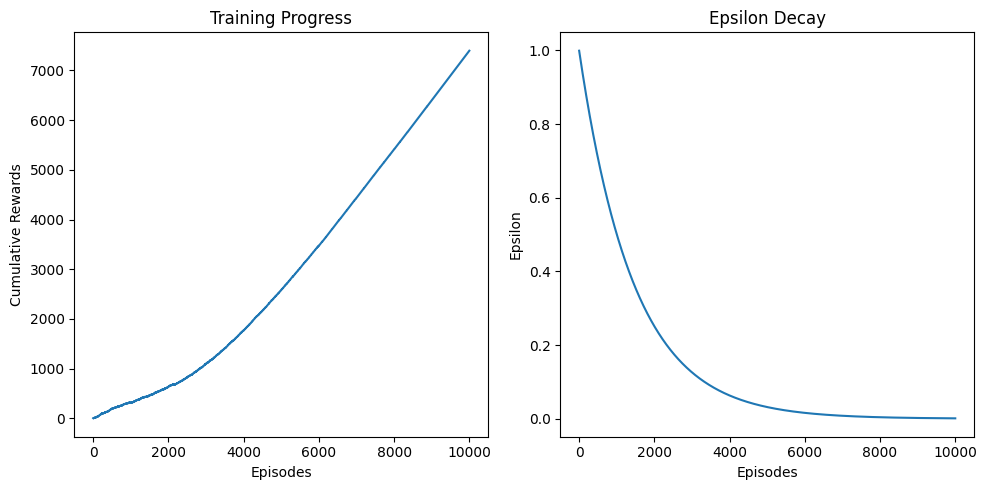

Training started at: 2023-05-16 00:33:19
Training ended at: 2023-05-16 03:55:23


In [8]:
import time

# Get the current time as the training start time
training_start_time = time.time()
print("Training started at:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(training_start_time)))

# Train the agents
train_agent(agent1, agent2, environment, replay_buffer, batch_size, episodes, learning_rate=learning_rate, discount_factor=discount_factor)

training_end_time = time.time()


# Print the training start and end time
print("Training started at:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(training_start_time)))
print("Training ended at:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(training_end_time)))

In [9]:
# Save the Q-network weights
q_network.model.save_weights('trained_policy_weights.h5')

<br>

## Testing

In [8]:
# Create an instance of the TicTacToeEnvironment
environment_play = TicTacToeEnvironment()

# Create a new instance of the Q-network
q_network_trained = QNetwork(state_size, action_size, learning_rate, discount_factor)

# Load the saved weights
q_network_trained.model.load_weights('trained_policy_weights.h5')

# Create an instance of the agent with the trained Q-network
trained_agent = Agent(q_network_trained, episodes)

In [9]:
# function to play the game between agent and human opponent
def play_game(agent, environment):
    environment.reset()
    state = environment.get_state()
    done = False
    result = None

    while not done:
        if environment.current_player == 1:
            # Agent's turn
            action = agent.play(state, environment.get_valid_actions())
            print("Agent's move:", action)
        else:
            # Human's turn
            valid_actions = environment.get_valid_actions()
            print("Valid actions:", valid_actions)
            sys.stdout.flush()

            # Display the input prompt
            display.display(display.HTML("<b>Your move (enter action number):</b>"))

            # Receive user input
            action = int(input())

            while action not in valid_actions:
                print("Invalid action. Please choose a valid action.")
                sys.stdout.flush()

                # Display the input prompt
                display.display(display.HTML("<b>Your move (enter action number):</b>"))

                # Receive user input
                action = int(input())

        reward = environment.update(action)
        state = environment.get_state()
        done = environment.game_over

        display.clear_output(wait=True)  # Clear previous output
        print("Current board state:")
        environment.print_board()

        if done:
            if reward == 1.0:
                if environment.current_player == 1:
                    print("Agent wins!")
                    result = "win"
                    time.sleep(3)
                else:
                    print("You win!")
                    result = "lose"
                    time.sleep(3)
            elif reward == 0.5:
                print("It's a draw!")
                result = "draw"
                time.sleep(3)
            else:
                print("Error: Invalid reward value.")
    
    return result



In [10]:
# Simulate a game between the trained agent and the human opponent
# Agent plays O
# Human plays X

play_game(trained_agent, environment_play)




Current board state:
-------------
| X | X | O | 
-------------
| O | O | X | 
-------------
| O |   |   | 
-------------
Agent wins!


'win'

In [13]:
# sumulate 25 games between the trained agent and the human opponent

num_games = 25
wins = 0
losses = 0
draws = 0

for _ in range(num_games):
    result = play_game(trained_agent, environment_play)
    
    if result == "win":
        wins += 1
    elif result == "lose":
        losses += 1
    else:
        draws += 1

print("Results:")
print("Wins:", wins)
print("Losses:", losses)
print("Draws:", draws)

Current board state:
-------------
| X | X | O | 
-------------
| O | O | X | 
-------------
| O |   |   | 
-------------
Agent wins!
Results:
Wins: 15
Losses: 1
Draws: 9
